In [2]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from pyspark.ml import PipelineModel
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
from pipeline_for_model_day.model_Day import model_Day

In [3]:
# Démarrer une session Spark
spark = SparkSession.builder.appName("Modelate").getOrCreate()

# Lire le CSV depuis HDFS ou local
df = spark.read.option("header", "true").csv("hdfs://localhost:9000/projet/gold/train_df")


25/05/25 20:53:06 WARN Utils: Your hostname, toma-Nitro-AN517-52 resolves to a loopback address: 127.0.1.1; using 192.168.88.15 instead (on interface wlp0s20f3)
25/05/25 20:53:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/25 20:53:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
loaded_pipeline_model = PipelineModel.load("/home/toma/Documents/BIGDATA/big_data_pipeline_v3")
df = loaded_pipeline_model.transform(df)
df.show(10)  # Afficher les 5 premières lignes du DataFrame
df.describe().show()  # Afficher les statistiques descriptives du DataFrame
df.printSchema()  # Afficher le schéma du DataFrame

25/05/25 20:53:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------+-------------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+-----------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+--------------------+-------------+--------------+--------------------------+--------------+------+
|   type|days_for_shipping_(real)|days_for_shipment_(scheduled)|benef

+-------+--------+------------------------+-----------------------------+------------------+------------------+----------------+------------------+------------------+------------------+-------------+----------------+--------------+--------------+------------------+--------------+-----------------+----------------+------------------+---------------+------------------+------------------+---------------+------------------+------------------+------+--------------+-------------+------------------+-----------------+----------------------+-------------------+------------------------+-----------------+------------------------+-----------------------+-------------------+------------------+------------------+----------------------+--------------+--------------+---------------+-----------------+-----------------+-------------------+-------------------+--------------------+--------------------+------------------+--------------+--------------+--------------------+
|summary|    type|days_for_shippin

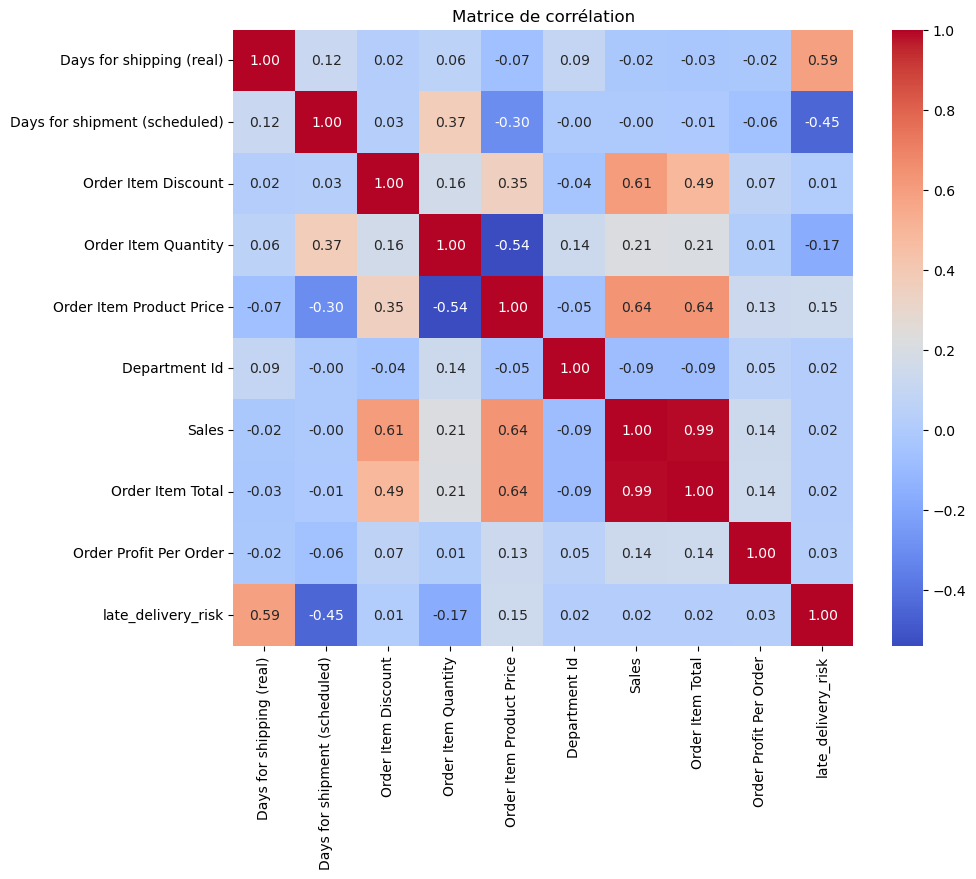

In [ ]:

numeric_cols = [
    "Days for shipping (real)",
    "Days for shipment (scheduled)",
    "Order Item Discount",
    "Order Item Quantity",
    "Order Item Product Price",
    "Department Id",
    "Sales",
    "Order Item Total",
    "Order Profit Per Order",
    "late_delivery_risk"
]
numeric_df = df.select(numeric_cols).limit(1000).toPandas()

# Matrice de corrélation
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

In [18]:

features = [
    "Days for shipment (scheduled)",
    "Shipping Mode",
    "order_city",
    "customer_city",
    "Product Card Id",
    "market",
    "late_delivery_risk"
]
features = [col.lower().replace(" ", "_") for col in features]

dfs = df.select(features)



In [30]:
train_df, test_df = dfs.randomSplit([0.6, 0.4], seed=42)
train_df.show(5)
test_df.show(5)

+-----------------------------+-------------+----------+-------------+---------------+------------+------------------+
|days_for_shipment_(scheduled)|shipping_mode|order_city|customer_city|product_card_id|      market|late_delivery_risk|
+-----------------------------+-------------+----------+-------------+---------------+------------+------------------+
|                            0|     Same Day|     Akola|       Caguas|           1014|Pacific Asia|                 0|
|                            0|     Same Day|    Albany|     Van Nuys|            365|Pacific Asia|                 1|
|                            0|     Same Day|    Albany|     Van Nuys|            403|Pacific Asia|                 1|
|                            0|     Same Day|    Albany|     Van Nuys|            502|Pacific Asia|                 1|
|                            0|     Same Day|    Albury|      Guayama|            191|Pacific Asia|                 1|
+-----------------------------+-------------+---

In [31]:
indexers = [
    StringIndexer(
        inputCol=col,
        outputCol=f"{col}_index",
        handleInvalid="keep"  # ✅ permet de gérer les labels non vus dans test_df
    )
    for col in ["market", "shipping_mode", "order_city", "customer_city"]
]

# Créer le pipeline
pipeline = Pipeline(stages=indexers)

# Entraîner le pipeline et transformer les données
model_pip = pipeline.fit(train_df)
train_df = model_pip.transform(train_df)
train_df.show(5)


+-----------------------------+-------------+----------+-------------+---------------+------------+------------------+------------+-------------------+----------------+-------------------+
|days_for_shipment_(scheduled)|shipping_mode|order_city|customer_city|product_card_id|      market|late_delivery_risk|market_index|shipping_mode_index|order_city_index|customer_city_index|
+-----------------------------+-------------+----------+-------------+---------------+------------+------------------+------------+-------------------+----------------+-------------------+
|                            0|     Same Day|     Akola|       Caguas|           1014|Pacific Asia|                 0|         2.0|                3.0|          1743.0|                0.0|
|                            0|     Same Day|    Albany|     Van Nuys|            365|Pacific Asia|                 1|         2.0|                3.0|           421.0|               99.0|
|                            0|     Same Day|    Albany

In [28]:
# ✅ Maintenant la sauvegarde doit marcher :
try:
    model_pip.save("./day_pipeline")
except Exception as e:
    model_pip.write().overwrite().save("./day_pipeline")

In [26]:
class SupplyChainDataset(Dataset):
    def __init__(self, dataframe):
        self.X_cat = dataframe[["market_index", "shipping_mode_index", "order_city_index", "customer_city_index"]].values
        self.X_num = dataframe[["product_card_id", "days_for_shipment_(scheduled)"]].values
        self.y = dataframe["late_delivery_risk"].values  # 0 ou 1

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return {
            "cat": torch.tensor(self.X_cat[idx], dtype=torch.long),
            "num": torch.tensor(self.X_num[idx], dtype=torch.float32),
            "target": torch.tensor(self.y[idx], dtype=torch.float32)  # binaire → float
       
        }


In [8]:
class SupplyChainModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.market_emb = nn.Embedding(5, 4)
        self.ship_emb = nn.Embedding(4, 4)
        self.country_emb = nn.Embedding(3597, 16)
        self.segment_emb = nn.Embedding(563, 8)

        # total embeddings + 3 features numériques
        self.fc1 = nn.Linear(4 + 4 + 16 + 8 + 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)  # 1 sortie pour binaire

    def forward(self, x_cat, x_num):
        e1 = self.market_emb(x_cat[:, 0])
        e2 = self.ship_emb(x_cat[:, 1])
        e3 = self.country_emb(x_cat[:, 2])
        e4 = self.segment_emb(x_cat[:, 3])
        x = torch.cat([e1, e2, e3, e4, x_num], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)  # pas de sigmoid ici (BCEWithLogitsLoss s'en charge)


In [134]:

dataset = SupplyChainDataset(train_df.toPandas())
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

model = SupplyChainModel()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epoch_losses = []
# Entraînement
for epoch in range(50):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_targets = []

    for batch in dataloader:
        x_cat = batch["cat"]
        x_num = batch["num"]
        y = batch["target"].unsqueeze(1)  # shape [batch_size, 1]

        y_pred = model(x_cat, x_num)
        loss = criterion(y_pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_losses.append(epoch_loss)
        preds = (torch.sigmoid(y_pred) > 0.5).int()
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_preds)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")



Epoch 1, Loss: 2176.2056, Accuracy: 0.6547, F1: 0.6595, AUC: 0.6595
Epoch 2, Loss: 1953.6697, Accuracy: 0.6895, F1: 0.6689, AUC: 0.7022
Epoch 3, Loss: 1924.5783, Accuracy: 0.6954, F1: 0.6752, AUC: 0.7081
Epoch 4, Loss: 1890.3602, Accuracy: 0.7024, F1: 0.6919, AUC: 0.7124
Epoch 5, Loss: 1861.5355, Accuracy: 0.7089, F1: 0.7052, AUC: 0.7168
Epoch 6, Loss: 1843.3224, Accuracy: 0.7128, F1: 0.7112, AUC: 0.7202
Epoch 7, Loss: 1822.8753, Accuracy: 0.7162, F1: 0.7165, AUC: 0.7229
Epoch 8, Loss: 1812.0340, Accuracy: 0.7186, F1: 0.7178, AUC: 0.7258
Epoch 9, Loss: 1796.6069, Accuracy: 0.7200, F1: 0.7201, AUC: 0.7269
Epoch 10, Loss: 1783.3544, Accuracy: 0.7228, F1: 0.7225, AUC: 0.7298
Epoch 11, Loss: 1769.5210, Accuracy: 0.7250, F1: 0.7256, AUC: 0.7317
Epoch 12, Loss: 1758.9903, Accuracy: 0.7263, F1: 0.7281, AUC: 0.7326
Epoch 13, Loss: 1746.9359, Accuracy: 0.7269, F1: 0.7274, AUC: 0.7337
Epoch 14, Loss: 1735.6738, Accuracy: 0.7289, F1: 0.7309, AUC: 0.7350
Epoch 15, Loss: 1723.4041, Accuracy: 0.7297

In [24]:
df = spark.read.option("header", "true").csv("hdfs://localhost:9000/projet/gold/test_df")
test_df = loaded_pipeline_model.transform(df)
pip_day = PipelineModel.load("./day_pipeline")
test_df = pip_day.transform(test_df)
test_df.show(5)

+-----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+----------------+-------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------+-----------+--------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+---------------+---------------+------------+-------------+---------------+-------------------+-------------------+--------------------+--------------------+-------------+--------------+--------------------------+--------------+------------+-------------------+----------------+-------------------+
| type|days_for_sh

In [27]:
test_dataset = SupplyChainDataset(test_df.toPandas())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_df = test_df.toPandas()

In [ ]:
model_late = torch.load("./late_modal.pt")
model_late.eval()  # mode évaluation
state_dict = model_late.state_dict()
torch.save(state_dict, "late_modal_weights_only.pt")
predictions = []
targets = []

In [29]:
with torch.no_grad():
    for batch in test_loader:
        x_cat = batch["cat"]
        x_num = batch["num"]
        y_true = batch["target"].unsqueeze(1)

        y_pred = model_late(x_cat, x_num)
        preds = (torch.sigmoid(y_pred) > 0.5).int()
        predictions.append(preds)
        targets.append(y_true)


test_df["late_delivery_risk"] = torch.cat(predictions, dim=0).squeeze().numpy()
# Identifier les colonnes à supprimer


In [30]:
cols_to_drop = [col for col in test_df.columns if "_index" in col]
# Supprimer ces colonnes
test_df = test_df.drop(cols_to_drop, axis=1)

test_df.head()

,type,days_for_shipping_(real),days_for_shipment_(scheduled),benefit_per_order,sales_per_customer,delivery_status,late_delivery_risk,category_id,category_name,customer_city,...,order_zipcode,product_card_id,product_category_id,product_description,product_image,product_name,product_price,product_status,shipping_date_(dateorders),shipping_mode
0,CASH,2,1,15.360000,122.839996,Late delivery,1,18,Men's Footwear,West Haven,...,95051,403,18,None,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,0,2016-08-03 23:42:00,First Class
1,CASH,3,4,2.340000,116.989998,Advance shipping,1,18,Men's Footwear,Caguas,...,None,403,18,None,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,0,2015-07-02 03:04:00,Standard Class
2,CASH,5,4,22.959999,164.000000,Late delivery,0,24,Women's Apparel,Phoenix,...,None,502,24,None,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,2017-07-10 04:40:00,Standard Class
3,CASH,5,4,55.610001,120.889999,Late delivery,0,18,Men's Footwear,Caguas,...,None,403,18,None,http://images.acmesports.sports/Nike+Men%27s+C...,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,0,2015-08-02 11:58:00,Standard Class
4,DEBIT,0,0,91.339996,260.980011,Shipping on time,1,43,Camping & Hiking,Tinley Park,...,None,957,43,None,http://images.acmesports.sports/Diamondback+Wo...,Diamondback Women's Serene Classic Comfort Bi,299.980011,0,2015-08-12 16:25:00,Same Day


In [38]:

# Fusionner tous les résultats
predictions = torch.cat(predictions, dim=0).squeeze().numpy()
targets = torch.cat(targets, dim=0).squeeze().numpy()


In [39]:
for pred, true in zip(predictions[:10], targets[:10]):
    print(f"Prédit: {pred}, Réel: {true}")



Prédit: 1, Réel: 0.0
Prédit: 1, Réel: 0.0
Prédit: 0, Réel: 1.0
Prédit: 0, Réel: 1.0
Prédit: 1, Réel: 1.0
Prédit: 1, Réel: 1.0
Prédit: 1, Réel: 1.0
Prédit: 0, Réel: 0.0
Prédit: 0, Réel: 0.0
Prédit: 0, Réel: 0.0


In [ ]:
print("Accuracy:", accuracy_score(targets, predictions))
print(classification_report(targets, predictions))

Accuracy: 0.7331133297130206
              precision    recall  f1-score   support

         0.0       0.68      0.78      0.73     32471
         1.0       0.80      0.69      0.74     39346

    accuracy                           0.73     71817
   macro avg       0.74      0.74      0.73     71817
weighted avg       0.74      0.73      0.73     71817



In [ ]:
torch.save(model, "late_modal.pt")


In [90]:


# Appliquer un seuil pour classifier
binary_preds = predictions
print("Accuracy:", accuracy_score(targets, binary_preds))
print("ROC AUC:", roc_auc_score(targets, predictions))


Accuracy: 0.7125471684977095
ROC AUC: 0.7207423650092207


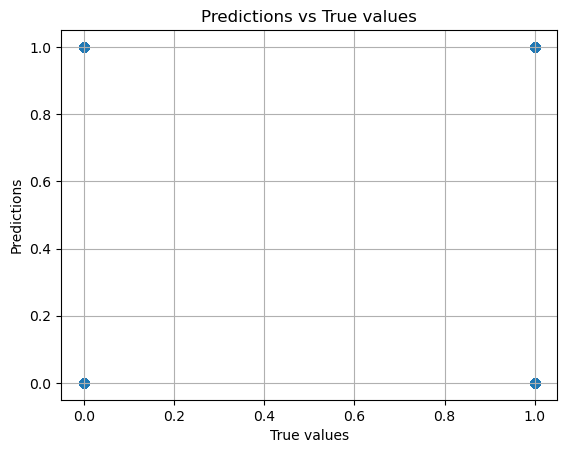

In [ ]:
plt.scatter(targets, predictions, alpha=0.5)
plt.xlabel("True values")
plt.ylabel("Predictions")
plt.title("Predictions vs True values")
plt.grid(True)
plt.show()


Epochs: [9.251351356506348, 13.015997648239136, 15.810312986373901, 19.72700524330139, 24.489161252975464, 27.87622094154358, 30.706275939941406, 32.263161420822144, 33.451748728752136, 35.47107684612274, 38.39050614833832, 39.867756962776184, 40.64794409275055, 41.978734254837036, 43.457115173339844, 44.95369243621826, 45.888856649398804, 46.73496878147125, 47.74372351169586, 48.71717309951782, 50.15627467632294, 51.099855959415436, 51.735042452812195, 52.54902219772339, 54.09757590293884, 56.07035231590271, 57.25825011730194, 57.91827839612961, 58.8368039727211, 60.91325479745865, 62.47194331884384, 63.90752595663071, 65.11633831262589, 65.85298746824265, 67.46468585729599, 68.60116297006607, 70.05114728212357, 71.28329747915268, 72.10041636228561, 72.85861164331436, 73.7792689204216, 74.9132804274559, 76.1462921500206, 76.88919645547867, 77.62540179491043, 78.92470842599869, 79.7459664940834, 80.58357411623001, 81.21873104572296, 81.85980862379074, 82.57592803239822, 83.276434063911

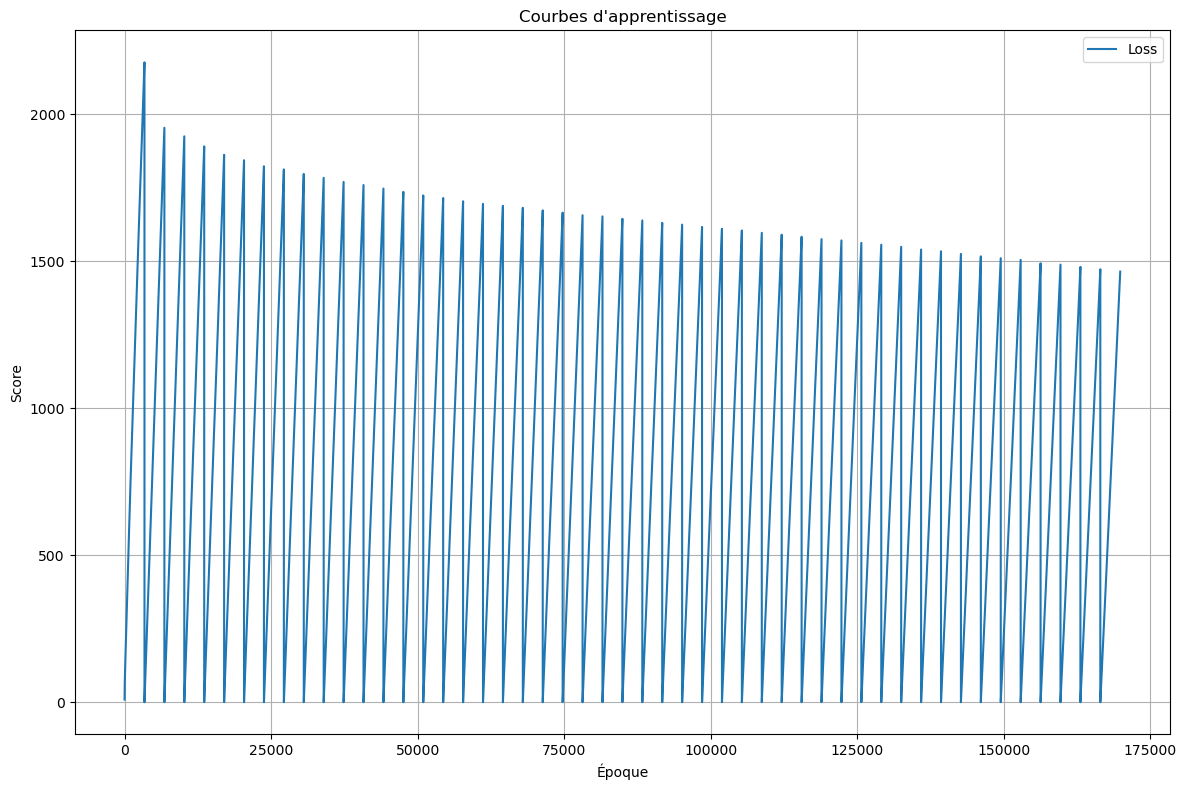

In [142]:
epochs = range(1, len(epoch_losses) + 1)
print("Epochs:", epoch_losses)
plt.figure(figsize=(12, 8))

# Courbe de la perte
plt.plot(epochs, epoch_losses, label="Loss")

plt.title("Courbes d'apprentissage")
plt.xlabel("Époque")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
spark.stop()